# Dataset and Benchmark creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <01_ADME_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit

import polaris 
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.dataset._column import Modality
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification
from polaris.utils.types import HubOwner, License

import os
import pathlib
os.chdir(pathlib.Path("__file__").parent.resolve().parent.absolute())
from utils import display_umap

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

In [2]:
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

In [3]:
BENCHMARK_DIR = "gs://polaris-public/benchmarks/ADME/fang2023"
DATASET_DIR = "gs://polaris-public/datasets/ADME/fang2023"

## Load existing data
> **Attention:** \
> The original dataset is published in [`Fang et al. 2023`](https://doi.org/10.1021/acs.jcim.3c00160). 
https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv \ \
> To **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.
> Therefore, the raw data from the data resource is not used here. 
> See more curation details in [01_ADME_data_curation.ipynb](https://github.com/polaris-hub/polaris-recipes/blob/mvp/01_ADME/01_ADME_data_curation.ipynb)

In [4]:
# Load data
PATH = 'gs://polaris-public/Data/ADME/fang2023_public_set_3521_curated.csv'
table = pd.read_csv(PATH)

### Below we specify the meta information of data columns

In [5]:
# Here we simplify the column names 
table = table.rename(columns={"molhash_id": "UNIQUE_ID",
                             "LOG HLM_CLint (mL/min/kg)": "LOG_HLM_CLint",
                            "LOG RLM_CLint (mL/min/kg)": "LOG_RLM_CLint",
                            "LOG MDR1-MDCK ER (B-A/A-B)":"LOG_MDR1-MDCK_ER",
                            "LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)": "LOG_HPPB",
                            "LOG PLASMA PROTEIN BINDING (RAT) (% unbound)": "LOG_RPPB",
                            "LOG SOLUBILITY PH 6.8 (ug/mL)": "LOG_SOLUBILITY"})

In [6]:
table.reset_index(drop=True, inplace=True)

Not all the columns are necessary, only the columns which are useful for the benchmarks will be annotated. Here we only use the columns that were used for training in the original paper. 

It's necessary to specify the key bioactivity columns, molecules structures and identifiers in dataset with `ColumnAnnotation`. It is possible to add `user_attributes` with any key and values when is needed, such as `unit`, `organism`, `scale` and optimization `objective`. 

**Abbrevations for the endpoint objective**
- THTB: the higher the better
- TLTB: the lower the better

In [7]:
annotations = {
    "UNIQUE_ID": ColumnAnnotation(
        description="Molecular hash ID. See <datamol.mol.hash_mol>"
    ),
    "smiles": ColumnAnnotation(
        description="Molecule SMILES string after cleaning and standardization.",
        modality=Modality.MOLECULE
    ),
    "ORIGINAL_SMILES": ColumnAnnotation(
        description="Original molecule SMILES string from the publication."
    ),  
    "LOG_HLM_CLint": ColumnAnnotation(
        description="Human liver microsomal stability reported as intrinsic clearance",
        user_attributes={
            "unit": "mL/min/kg",
            "scale": "log",
            "organism": "human",
            "objective": "TLTB",
        },
    ),
    "LOG_RLM_CLint": ColumnAnnotation(
        description="Rat liver microsomal stability reported as intrinsic clearance",
        user_attributes={
            "unit": "mL/min/kg",
            "scale": "log",
            "organism": "rat",
            "objective": "TLTB",
        },
    ),
    "LOG_MDR1-MDCK_ER": ColumnAnnotation(
        description="MDR1-MDCK efflux ratio (B-A/A-B)",
        user_attributes={"unit": "mL/min/kg", "scale": "log", "objective": "THTB"},
    ),
    "LOG_HPPB": ColumnAnnotation(
        description="Human plasma protein binding",
        user_attributes={"unit": "% unbound", "objective": "TLTB"},
    ),
    "LOG_RPPB": ColumnAnnotation(
        description="Rat plasma protein binding",
        user_attributes={"unit": "% unbound", "objective": "TLTB"},
    ),
    "LOG_SOLUBILITY": ColumnAnnotation(
        description="Solubility was measured after equilibrium between the dissolved and solid state",
        user_attributes={
            "unit": "ug/mL",
            "scale": "log",
            "PH": "6.8",
            "objective": "THTB",
        },
    )
}

### Define `Dataset` object

In [8]:
dataset_name = "fang2023_ADME_public_v1"
with open(f"readme/datasets/{dataset_name}_readme.md") as f:
    dataset_readme = f.read()

In [9]:
dataset = Dataset(
    table=table[annotations.keys()],
    name="Fang_2023_ADME_public",
    description="Disclosed ADME datasets collected over 20 months across six ADME in vitro endpoints",
    source="https://doi.org/10.1021/acs.jcim.3c00160",
    annotations=annotations,
    owner=owner,
    tags=["ADME"], 
    readme=dataset_readme
)

In [10]:
# save the dataset
SAVE_DIR = f"{DATASET_DIR}/{dataset_name}"
dataset.to_json(SAVE_DIR)

'gs://polaris-public/datasets/ADME/fang2023/fang2023_ADME_public_v1/dataset.json'

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

## Single task training performance compare to the results from paper Fang2023 as baseline.
The tasks use the same test sets as in the fang2023 paper.
Here we create a single task benchmark for each the six ADME endpoints.
The test set was created based on the train and test split provided in https://github.com/molecularinformatics/Computational-ADME/tree/main/MPNN. \
The dataset is slightly different to the dataset published in Fang et al. 2023 after removing the undesired molecules in the context of small molecules.

In [11]:
# Specify names and extract the test set from their dataset
endpoints = {
    "HLM": "HLM_CLint",
    "RLM": "RLM_CLint",
    "hPPB": "HPPB",
    "rPPB": "RPPB",
    "MDR1_ER": "MDR1-MDCK_ER",
    "Sol": "SOLUBILITY",
}

_endpoint = list(endpoints.keys())
INDIR = "gs://polaris-public/Data/ADME/fang2023/MPNN"

(618, 2)
(575,)
(611, 2)
(559,)
(362, 2)
(37,)
(177, 2)
(28,)
(529, 2)
(483,)
(435, 2)
(400,)


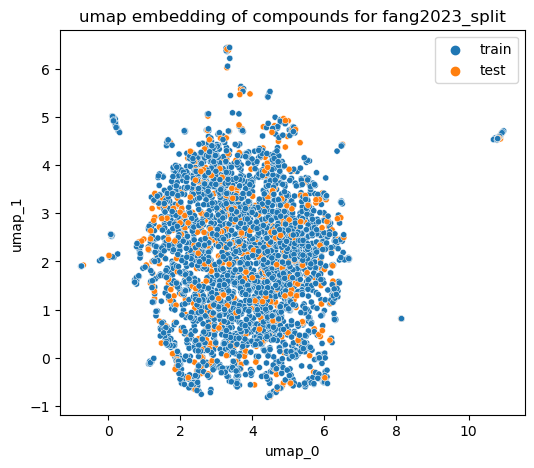

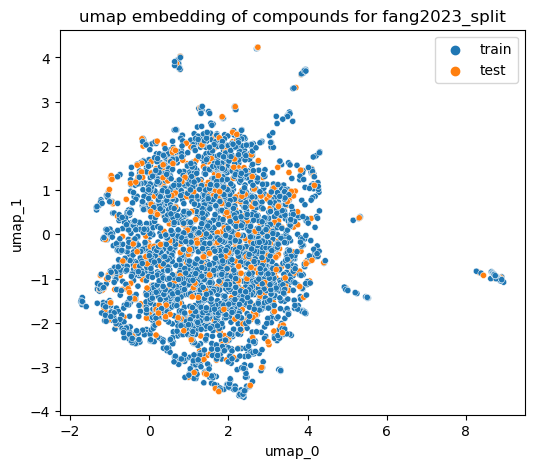

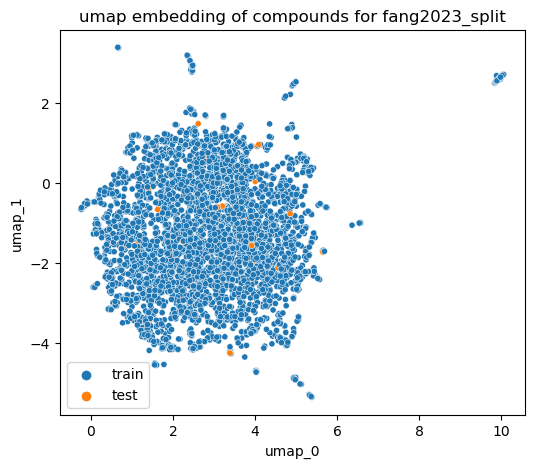

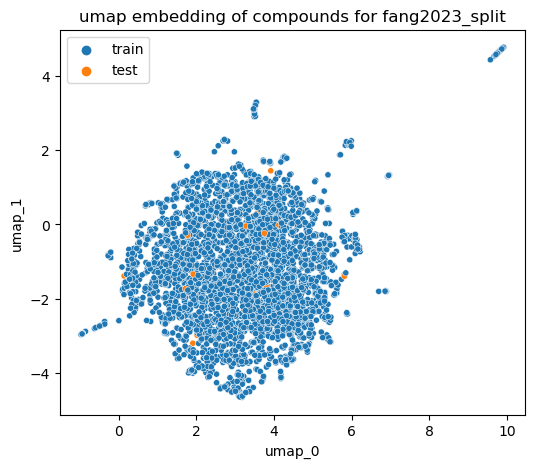

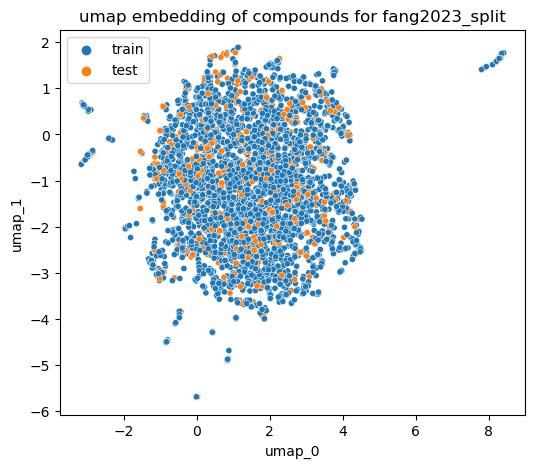

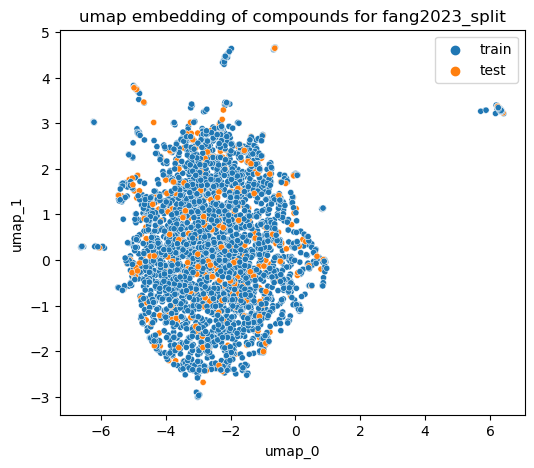

In [12]:
split_key = "fang2023split"
paper_splits = {}
for endpoint in _endpoint:
    testset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_test.csv")
    print(testset.shape)
    paper_splits[endpoints[endpoint]] = (
        table.loc[~table.SMILES.isin(testset.smiles)].index.values,
        table.loc[table.SMILES.isin(testset.smiles)].index.values,
    )
    print(table.loc[table.SMILES.isin(testset.smiles)].index.values.shape)
    fig = display_umap(data=table, mol_col="smiles", 
                       split=paper_splits[endpoints[endpoint]], split_name="fang2023_split",
                      method="umap")
    fig.savefig(f"figures/{dataset_name}_umap_{endpoint}_split.png")

In [13]:
data_cols = ['LOG_HLM_CLint', 'LOG_RLM_CLint', 'LOG_MDR1-MDCK_ER', 'LOG_HPPB', 'LOG_RPPB','LOG_SOLUBILITY']

## Create a Benchmark for Fang et al. 2023 dataset
### The train/test sets are pre-defined from fang et al. 2023 

In [14]:
benchmark_version = "v1"

In [15]:
benchmark_path = {}
split_key = 'fang2023_split'
for target_col in data_cols:
    benchmark_name=f"fang2023_ADME_public_single_reg_{target_col}"
    with open(f"readme/benchmarks/{benchmark_name}_readme.md") as f:
        benchmark_readme = f.read()
    benchmark = SingleTaskBenchmarkSpecification(
        name=benchmark_name,
        dataset=dataset,
        target_cols=target_col,
        input_cols=["smiles"],
        split=paper_splits[target_col.replace("LOG_", "")],
        main_metric="mean_squared_error",
        metrics=["mean_absolute_error",
                "mean_squared_error",
                "r2",
                "spearmanr",
                "pearsonr",
                "explained_var"],
        tags=['ADME', 'Singletask'], 
        owner=owner, 
        description=f"Single task benchmark for {target_col}",
        readme=benchmark_readme
    )
    BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
    path = benchmark.to_json(BENCHMARK_SAVE_DIR)
    print(path)

gs://polaris-public/benchmarks/ADME/fang2023/fang2023_ADME_public_single_reg_LOG_HLM_CLint/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/fang2023_ADME_public_single_reg_LOG_RLM_CLint/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/fang2023_ADME_public_single_reg_LOG_MDR1-MDCK_ER/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/fang2023_ADME_public_single_reg_LOG_HPPB/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/fang2023_ADME_public_single_reg_LOG_RPPB/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/fang2023_ADME_public_single_reg_LOG_SOLUBILITY/benchmark.json


## Multitask for all the six ADME endpoints with a common random split. 

In [16]:
# regression
TEST_SIZE = 0.2
SEED = 111

# random split
random_splitter = ShuffleSplit(n_splits=5, test_size=TEST_SIZE, random_state=SEED)
random_split = next(random_splitter.split(X=dataset.table.smiles.values))
split_key = "random"

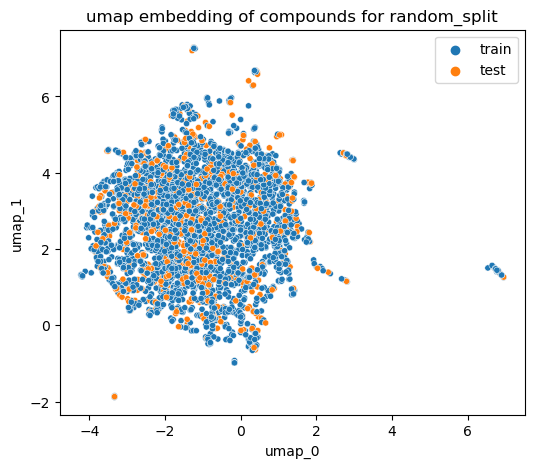

In [17]:
from utils import display_umap
fig = display_umap(data=table, mol_col="smiles", 
                   split=random_split, split_name="random_split",
                  method="umap")
fig.savefig(f"figures/{dataset_name}_umap_{split_key}_split.png")

In [18]:
benchmark_version = "v1"
benchmark_name=f"fang2023_ADME_public_multitask_reg_{benchmark_version}"

In [19]:
with open(f"readme/benchmarks/{benchmark_name}_readme.md") as f:
    benchmark_readme = f.read()

In [20]:
benchmark_multi = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=random_split,
    tags=["ADME", "Multitask"], 
    owner=owner,
    description="A multitask benchmark for all the ADME endpoints with a common random split. ",
    main_metric="mean_squared_error",
    metrics=["mean_absolute_error",
            "mean_squared_error",
            "r2",
            "spearmanr",
            "pearsonr",
            "explained_var"], 
    readme = benchmark_readme
)
SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_multi.to_json(SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/ADME/fang2023/fang2023_ADME_public_multitask_reg_v1/benchmark.json
